In [1]:
from typing import Optional
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

from rpy2 import robjects
from src.visualization import projection

In [2]:
### Constants

COHORT = "CESC"
INTERIM_DATA_DIR = Path("../data/interim/TCGA")
COUNTS_FILE = INTERIM_DATA_DIR / f"counts/{COHORT}.csv.gz"
if not COUNTS_FILE.exists():
    raise FileNotFoundError(
        f"{COUNTS_FILE} does not exist. Run `0_preprocess_and_label.ipynb` first."
    )
COLDATA_FILE = INTERIM_DATA_DIR / f"coldata/{COHORT}.csv"
VST_DIR = INTERIM_DATA_DIR / "vst"
assert COLDATA_FILE.exists()
FIGURES_DIR = Path("../reports/figures")
assert FIGURES_DIR.exists()

## 1. Prep: Variance Stabilizing Transformation (VST)

In [4]:
robjects.r('suppressPackageStartupMessages(library("src"))')
vst_transform = robjects.r["vst_transform"]
VST_DIR.mkdir(exist_ok=True, parents=True)
design_formula_cols = ["stage", "grade"]
vst_transform(str(COUNTS_FILE), str(COLDATA_FILE), str(VST_DIR), design_formula_cols)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: replacing previous import ‘data.table::last’ by ‘dplyr::last’ when loading ‘src’ 

R[write to console]: 2: replacing previous import ‘data.table::first’ by ‘dplyr::first’ when loading ‘src’ 

R[write to console]: 3: replacing previous import ‘data.table::between’ by ‘dplyr::between’ when loading ‘src’ 

R[write to console]: 4: replacing previous import ‘dplyr::select’ by ‘AnnotationDbi::select’ when loading ‘src’ 

R[write to console]: 5: replacing previous import ‘AnnotationDbi::select’ by ‘clusterProfiler::select’ when loading ‘src’ 

R[write to console]: 6: replacing previous import ‘ggplot2::last_plot’ by ‘plotly::last_plot’ when loading ‘src’ 

R[write to console]: 7: replacing previous import ‘ggpubr::color_palette’ by ‘enrichplot::color_palette’ when loading ‘src’ 



Design formula: ~ stage + grade 
VST transformed data written to: ../data/interim/TCGA/vst/CESC.csv.gz 


<rpy2.rinterface_lib.sexp.NULLType object at 0x7f05eaf61190> [0]

In [3]:
vst_file = VST_DIR / f"{COHORT}.csv.gz"
vst_expr = pd.read_csv(vst_file, index_col=0)

## 2. Dimensionality Reduction: PCA and UMAP

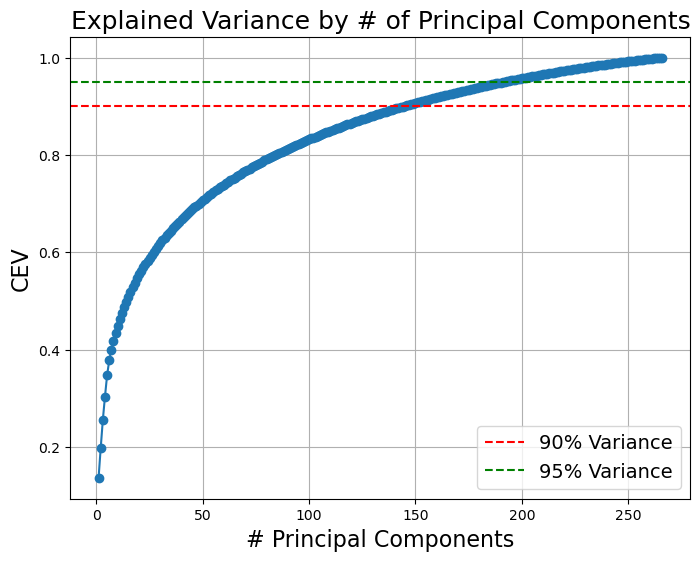

In [4]:
# Plot explained variance
projection.plot_explained_variance(vst_expr.T)

In [5]:
coldata = pd.read_csv(COLDATA_FILE, index_col=0)
assert np.all(vst_expr.columns == coldata.index)

n_components = 6
n_umap_dims = 3

pca = PCA(n_components=n_components)
pca_expr = pca.fit_transform(vst_expr.T)
pca_expr = pd.DataFrame(
    pca_expr, index=vst_expr.columns, columns=[f"PC-{i+1}" for i in range(n_components)]
)
explained_variance = pca.explained_variance_ratio_
# Add metadata
pca_expr = pca_expr.join(coldata)
pca_expr = pca_expr.loc[pca_expr["PT_resistant"].isin(("Yes", "No"))]
pca_expr["stage/grade"] = pca_expr["stage"].str.cat(pca_expr["grade"], sep="/")

umap_model = umap.UMAP(n_components=n_umap_dims, random_state=1)
umap_expr = umap_model.fit_transform(vst_expr.T)
umap_expr = pd.DataFrame(
    umap_expr,
    index=vst_expr.columns,
    columns=[f"UMAP-{i+1}" for i in range(n_umap_dims)],
)
# Add metadata
umap_expr = umap_expr.join(coldata)
umap_expr = umap_expr.loc[umap_expr["PT_resistant"].isin(("Yes", "No"))]
umap_expr["stage/grade"] = umap_expr["stage"].str.cat(umap_expr["grade"], sep="/")

/home/noah/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [6]:
pca_fig = projection.interactive_scatterplot(
    pca_expr,
    "stage/grade",
    "PT_resistant",
    n_components,
    title="3D PCA (Drag to rotate, scroll to zoom, ctrl+drag to pan)",
    explained_variance=explained_variance,
)
pca_fig.write_html(FIGURES_DIR / f"pca_{COHORT}.html")

In [14]:
umap_fig = projection.interactive_scatterplot(
    umap_expr, "stage/grade", "PT_resistant", n_umap_dims, title="3D UMAP"
)
umap_fig.write_html(FIGURES_DIR / f"umap_{COHORT}.html")